In [4]:
import spacy
import requests      # For downloading things
import pandas as pd  # For data sciencey stuff
import numpy as np   # For binning
from collections import Counter # For counting

In [11]:
import en_core_web_md
nlp = en_core_web_md.load()
#nlp =  spacy.load('en_core_web_md')

In [12]:
# Or use the default model, which has fewer features:
#nlp = spacy.load('en')
#nlp = en_core_web_md.load()

In [13]:
# I shortened these links to make them easier to type during the workshop, 
# but they just point to files here: https://github.com/JonathanReeve/advanced-text-analysis-workshop-2017
grailRaw = requests.get('http://bit.ly/grail-txt').text
prideRaw = requests.get('http://bit.ly/pride-txt').text

In [40]:
# If I have those files in my local directory, I can just run: 
prideRaw = open('pride.txt').read()
grailRaw = open('grail.txt').read()

In [41]:
print(grailRaw[:200]) # Sanity check

SCENE 1: [wind] [clop clop clop] 
KING ARTHUR: Whoa there!  [clop clop clop] 
SOLDIER #1: Halt!  Who goes there?
ARTHUR: It is I, Arthur, son of Uther Pendragon, from the castle of Camelot.  King of t


In [42]:
print(prideRaw[:200])

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first ente


In [43]:
grail = nlp(grailRaw)

In [44]:
type(grail)

spacy.tokens.doc.Doc

In [45]:
pride = nlp(prideRaw)

In [46]:
type(pride)

spacy.tokens.doc.Doc

## What properties does this Doc object have? 

In [47]:
[prop for prop in dir(grail) if not prop.startswith('_')]

['cats',
 'char_span',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_disk',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'merge',
 'noun_chunks',
 'noun_chunks_iterator',
 'print_tree',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'to_bytes',
 'to_disk',
 'to_json',
 'to_utf8_array',
 'user_data',
 'user_hooks',
 'user_span_hooks',
 'user_token_hooks',
 'vector',
 'vector_norm',
 'vocab']

SpaCy processes everything all at once, which explains why the command above takes so long. It's doing named entity recognition, looking up word vectors, doing POS tagging, and performing other tasks. 

## How many words are there in a text? 

In [48]:
len(grail), len(pride)

(18522, 155435)

In [49]:
len(pride)

155435

In [50]:
grail[15] # The sixteenth word

Whoa

## How many sentences are there? 

In [51]:
type(grail.sents)

generator

## Side note: on generators

Generators are functions that behave as iterators, i.e., you can iterate over them with a `for` loop, like you would with a list. But you can't index them. So this works: 

```python
for sent in grailDoc.sents: 
  print(sent)
```

But not this: 

```python
print(grailDoc.sents[0]) # Doesn't work
```

However, you can force a generator into a list, using `list()`, and then index it. So to get the first sentence of _Pride and Prejudice_, one could write:

```python
list(pride.sents)[0]
```

But actually if we just want the first one, we can do this: 

```python
next(pride.sents)
```

## How many sentences are there in _Pride and Prejudice_? 

In [55]:
next(pride.sents)

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.


In [52]:
len(list(pride.sents))

6783

## What's the longest sentence in _Pride and Prejudice_?

In [58]:
prideDoc = list(pride.sents)
prideDoc[-1]

Darcy, as well as Elizabeth, really loved them; and they were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.

In [56]:
prideSents = list(pride.sents)
prideSents[-1]

Darcy, as well as Elizabeth, really loved them; and they were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.

In [57]:
prideSentenceLengths = [len(sent) for sent in prideSents]
[sent for sent in prideSents if len(sent) == max(prideSentenceLengths)]

[that proud and repulsive as
 were his manners, she had never, in the whole course of their
 acquaintance--an acquaintance which had latterly brought them much
 together, and given her a sort of intimacy with his ways--seen anything
 that betrayed him to be unprincipled or unjust--anything that spoke him
 of irreligious or immoral habits; that among his own connections he was
 esteemed and valued--that even Wickham had allowed him merit as a
 brother, and that she had often heard him speak so affectionately of his
 sister as to prove him capable of _some_ amiable feeling; that had his
 actions been what Mr. Wickham represented them, so gross a violation of
 everything right could hardly have been concealed from the world; and
 that friendship between a person capable of it, and such an amiable man
 as Mr. Bingley, was incomprehensible.
 ]

In [61]:
prideSentLengths = [len(sent) for sent in prideDoc]
[sent for sent in prideDoc if len(sent) == max(prideSentLengths)]

[that proud and repulsive as
 were his manners, she had never, in the whole course of their
 acquaintance--an acquaintance which had latterly brought them much
 together, and given her a sort of intimacy with his ways--seen anything
 that betrayed him to be unprincipled or unjust--anything that spoke him
 of irreligious or immoral habits; that among his own connections he was
 esteemed and valued--that even Wickham had allowed him merit as a
 brother, and that she had often heard him speak so affectionately of his
 sister as to prove him capable of _some_ amiable feeling; that had his
 actions been what Mr. Wickham represented them, so gross a violation of
 everything right could hardly have been concealed from the world; and
 that friendship between a person capable of it, and such an amiable man
 as Mr. Bingley, was incomprehensible.
 ]

## What words appear more in exclamatory sentences? 

In [62]:
excl = [sent for sent in pride.sents if '!' in sent.text]
exclCounts = pd.Series(Counter([word.lemma_ for sent in excl for word in sent if not word.is_punct and not word.is_space]))
noExcl = [sent for sent in pride.sents if '!' not in sent.text]
noExclCounts = pd.Series(Counter([word.lemma_ for sent in noExcl for word in sent if not word.is_punct and not word.is_space]))

In [63]:
(exclCounts - noExclCounts).sort_values(ascending=False).head(10)

oh          81.0
Heaven       9.0
Lord         8.0
gracious     4.0
Good         4.0
ah           3.0
strange      2.0
fun          2.0
Tis          1.0
ankle        1.0
dtype: float64

## Exploring properties of words (tokens)

In [64]:
universally = prideDoc[4]
type(universally)

spacy.tokens.span.Span

In [65]:
[prop for prop in dir(universally) if not prop.startswith('__')]

['_',
 '_fix_dep_copy',
 '_recalculate_indices',
 '_vector',
 '_vector_norm',
 'as_doc',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'upper_',
 'vector',
 'vector_norm',
 'vocab']

In [136]:
universally.ent_id, universally.end_char


(0, 617)

In [70]:
universally.lower_

'“but it is,” returned she; “for mrs. long has just been here, and she\ntold me all about it.”'

In [75]:
#prideDoc[universally.sent:universally.ents+1]
prideDoc[4:16]

[“But it is,” returned she; “for Mrs. Long has just been here, and she
 told me all about it.”
 ,
 Mr. Bennet made no answer.
 ,
 “Do you not want to know who has taken it?” cried his wife impatiently.
 ,
 “_,
 You_ want to tell me, and I have no objection to hearing it.”
 ,
 This was invitation enough.
 ,
 “Why, my dear, you must know, Mrs. Long says that Netherfield is taken
 by a young man of large fortune from the north of England; that he came
 down on Monday in a chaise and four to see the place, and was so much
 delighted with it, that he agreed with Mr. Morris immediately; that he
 is to take possession before Michaelmas, and some of his servants are to
 be in the house by the end of next week.”
 ,
 “What is his name?”
 ,
 “Bingley.”
 ,
 “Is he married or single?”
 ,
 “Oh!,
 Single, my dear, to be sure!]

In [133]:
print(type(prideDoc))

<class 'list'>


In [156]:
for word in prideDoc:
    print(type(word))
    #break
    if 'dear' in word.text:
        #print(word.end_char)
        break
        
        
pd.Series([int(word.end_char) for word in prideDoc if 'dear' in 'word.text'])

<class 'spacy.tokens.span.Span'>
<class 'spacy.tokens.span.Span'>
<class 'spacy.tokens.span.Span'>


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


Series([], dtype: float64)

In [160]:
#excl = [sent for sent in pride.sents if '!' in sent.text]
#pd.Series([word.end_char  for word in prideDoc if 'dear' in 'word.text']).hist(figsize=(12,6))
#pd.Series([word.i for word in prideDoc if word.text == 'love']).hist(figsize=(12,6))

pd.Series([word.i for word in pride if word.text == w]).hist(figsize=(12,6))

TypeError: Argument 'other' has incorrect type (expected spacy.tokens.token.Token, got str)

## Side note: on testing for word equality

SpaCy tests equality of _tokens_ but not _types_. This means that a word that is orthographically identical to another isn't necessarily identical according to Python's equality (`==`) operator. For example: 

In [79]:
universally == universally

True

In [80]:
type(universally)

spacy.tokens.span.Span

In [81]:
anotherUniversally = nlp("universally")[0]

In [82]:
type(anotherUniversally)

spacy.tokens.token.Token

In [83]:
universally == anotherUniversally

TypeError: Argument 'other' has incorrect type (expected spacy.tokens.span.Span, got spacy.tokens.token.Token)

In [85]:
universally.ents

[Long]

In [86]:
bennet = [w for w in pride if w.text == 'Bennet'][0]

In [87]:
bennet.ent_type

380

## Word probability and rank

SpaCy maintains data about word probabilities and word rank, according to what it's seen before in its training data. This can be useful for looking at certain slices of a text (its most frequent function words, or its lesser-frequent content words). 

**Warning:** This only seems to work with `en_core_web_md` and `en_core_web_lg`. 

In [88]:
set([(w.text, w.rank) for w in pride[:2000] if w.rank > 15000 and w.ent_type == 0])

{('Bingley', 19468),
 ('Impossible', 16582),
 ('Kitty', 16496),
 ('acquaintance', 19142),
 ('acquainted', 19142),
 ('chaise', 17220),
 ('coughing', 17603),
 ('coughs', 17603),
 ('delight', 19198),
 ('exclamation', 18862),
 ('honour', 15400),
 ('impatiently', 17909),
 ('insufficient', 16315),
 ('morrow', 15967),
 ('neices', 18507),
 ('neighbourhood', 17105),
 ('nieces', 18877),
 ('persuade', 16836),
 ('quickness', 19526),
 ('resentfully', 17755),
 ('scolding', 16154),
 ('servants', 15938),
 ('solace', 16404),
 ('tumult', 16065),
 ('vexing', 18170)}

In [92]:
for w in next(pride.sents):
  if w.prob < -10:
    print(w, w.prob)

universally -12.210193634033203
acknowledged -12.411476135253906
possession -11.476877212524414
fortune -12.021092414855957


## Using word indices

We can use the `.i` property to find the distribution of these words in "narrative time," that is, an index of `1` would mean that it's the second word in the text. 

In [159]:
print(type(pride))

<class 'spacy.tokens.doc.Doc'>


In [93]:
def getIndices(w):
  hist, bins = np.histogram(pd.Series([word.i for word in pride if word.text == w]), bins=50)
  return hist

In [94]:
wordList = ['love', 'hate', 'pride', 'prejudice']
characterList = ['Darcy', 'Elizabeth', 'Jane', 'Bingley']
wordIndices = [getIndices(w) for w in wordList]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

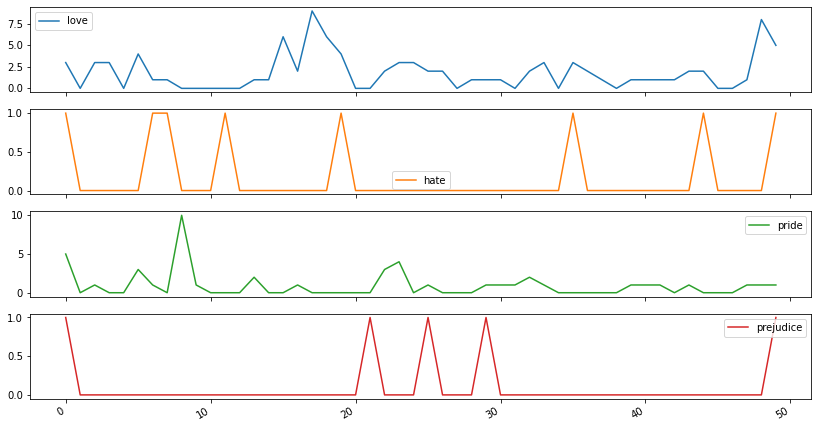

In [95]:
wordsDF = pd.DataFrame(wordIndices, index=wordList).T
wordsDF.plot(subplots=True, figsize=(14,8))

In [96]:
wordsDF.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,love,hate,pride,prejudice
love,1.00,0.11,0.00,0.06
hate,0.11,1.00,-0.01,0.22
pride,0.00,-0.01,1.00,0.14
prejudice,0.06,0.22,0.14,1.00


In [97]:
def narrativeTime(w, text):
  return np.histogram(pd.Series([word.i for word in text 
           if word.lemma_ == w]), 50)[0]

def wordCorrelation(wordlist, text):
  df = pd.DataFrame([narrativeTime(w, text)
                 for w in wordlist], index=wordlist)
  return df.T.corr().style.background_gradient(cmap='coolwarm')

In [98]:
wordCorrelation(['Jane', 'Elizabeth', 'Darcy', 'Bingley'], 
                pride)

,Jane,Elizabeth,Darcy,Bingley
Jane,1.000000,0.075799,-0.258867,0.183711
Elizabeth,0.075799,1.000000,0.051756,0.072323
Darcy,-0.258867,0.051756,1.000000,0.329778
Bingley,0.183711,0.072323,0.329778,1.000000


## Exploring named entities

In [99]:
set([w.label_ for w in grailDoc.ents])

NameError: name 'grailDoc' is not defined

In [0]:
entSents = [ent.sent for ent in grailDoc.ents if ent.label_ == 'WORK_OF_ART']
entSents

[The Tale of Sir Robin.  ,
 The Castle Anthrax?,
 Oh, wicked, wicked Zoot.  ,
 HEAD KNIGHT: I cannot tell, suffice to say is one of the words the Knights of Ni cannot hear.,
 Consult the Book of Armaments!,
 Once the number three, being the third number, be reached, then lobbest thou thy Holy Hand Grenade of Antioch towards thy foe, who, being naughty in my sight, shall snuff it.',
 It's Aramaic!,
 It's the legendary Black Beast of Aaauugh!,
 [Black Beast of Aaauugh eats BROTHER MAYNARD] ,
 As the horrendous Black Beast lunged forward, escape for Arthur and his knights seemed hopeless, when suddenly, the animator suffered a fatal heart attack.]

In [0]:
spacy.displacy.render(entSents[4], style='ent', jupyter=True)

## Parts of speech

### Get the first fifty nouns in _Pride and Prejudice_

In [100]:
print([w for w in pride if w.pos_ == 'NOUN'][:50])

[truth, man, possession, fortune, want, wife, feelings, views, man, neighbourhood, truth, minds, families, property, daughters, lady, day, answer, wife, _, _, objection, invitation, dear, man, fortune, north, chaise, place, possession, servants, house, end, week, name, dear, man, fortune, year, thing, girls, wife, design, Design, Nonsense, _, love, occasion, girls, dear]


## Dependency Parsing

In [103]:
spacy.displacy.render(next(pride.sents), jupyter=True, options={'compact': True, 'collapse_punct': True, 'collapse_phrases': True})

## Navigating the dependency-parsed tree

We can use the `root` method to find the root verb of a sentence, and the `.children` and `.ancestors` properties to navigate up and down the tree. 

In [104]:
pride1 = next(pride.sents)
pride1.root

is

In [105]:
list(pride1.root.children)

[It, truth, .]